# Industrial Applications of Artificial Intelligence - Bias in Credit Decisions

### This notebook is part of the third hand-in regarding the secondary sector in the lecture Industrial Applications of AI by Niklas Sabel (Matr. no. 1599748)

Credit decisions, personal potential evaluation or support in judgements. Machine Learning algorithms are touching more and more areas of people's personal lives. However, this is not always benefitial. A sensation has been caused in 2016 by the publication of ProPublica about the software COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) that should help in discovering the underlying risk of a criminal becoming a recidivist [[1]](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing). The authors found out that the algorithm is highly biased towards black people such that "black defendants are far more likely than white defendants to be incorrectly judged to be at a higher risk of recidivism" [[2]](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm). This impressively illustrates that if developers and designers are not careful, human bias is picked up by algorithms leading to highly unfair results. Therefore, one has to be especially cautious involving personal sensitive data, for example sex, political attitude or religious affiliation. In the following notebook, we explore the influence of sensitive information in the case of loan offers and investigate how sensitive data can influence the decision.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer

## I. Data Exploration

The dataset can be found on kaggle unter the following [URL](https://www.kaggle.com/datasets/jannesklaas/model-trap). The author created the dataset for pedagogic purposes to teach students how bias can affect the outcomes of models. It reflects the decisions if a person is offered a loan or not, but is generated that a default models is most likely to be biased again women and minorities. 
First of all, the dataset consists out of 480,000 entries containing 13 features and one target targets, which will be described in the following. We are also given a test set with 160,000 features and the same amount of features that will be kept separated until the end.
* Minority: Binary variable that indicates wether a person belongs to a minority (0) or not (1).
* Sex: Binary variable that indicates wether a person is male (0) or female (1).
* ZIP: Integer that indicates the area where a person lives. 
* Rent: Binary variable that indicates wether a person currently pays rent (1) or not (0).
* Education: Float number indicating the education of a person. Unfortunately, no description is given and that makes it hard to interpret.
* Age: Float number indicating the age of a person.
* Income: Float number indicating the income of a person. Unfortunately, no currency is given.
* Loan size: Float number indicating the loan amount a person requests. Unfortunately, no currency is given.
* Payment timing: Float number indicating the payment timinig of a person. Unfortunately, no description is given and that makes it hard to interpret and decide which belongs to late or not late.
* Year: Integer that indicates the year when a person requested the loan. 
* Job Stability: Float number indicating the job stability of a person. Unfortunately, no description is given and that makes it hard to interpret.
* Occupation: Integer that indicates the employment type that a person has. 
* Default: Target. Binary variable that indicates wether a person gets a loan (1) or not (0).

Unfortunately, there is no explanation for the variables and in most cases they are not self-explaining. However, as we want to focus on the influence of minority and sex, we do not need to specific information about the other features.

In [3]:
dir_path ='../../src/data/Abgabe_3/'

In [4]:
df = pd.read_csv(os.path.join(dir_path, "train.csv"))
df.head(10)

,minority,sex,ZIP,rent,education,age,income,loan_size,payment_timing,year,job_stability,default,occupation
0,1,0,MT04PA,1,57.230650,36.050927,205168.022244,7600.292199,3.302193,0,3.015554,True,MZ10CD
1,1,0,MT04PA,1,45.891343,59.525251,187530.409981,5534.271289,3.843058,0,5.938132,True,MZ10CD
2,1,0,MT04PA,1,46.775489,67.338108,196912.006690,2009.903438,2.059034,0,2.190777,True,MZ10CD
3,1,0,MT04PA,1,41.784839,24.067401,132911.650615,3112.280893,3.936169,0,1.725860,True,MZ10CD
4,1,0,MT04PA,1,41.744838,47.496605,161162.551205,1372.077093,3.709910,0,0.883104,True,MZ10CD
5,1,0,MT04PA,1,55.330391,34.986911,196698.100755,9807.367705,3.778435,0,3.827745,True,MZ10CD
6,1,0,MT04PA,0,52.697992,25.513529,170699.801788,6978.556887,3.847329,0,1.266106,True,MZ10CD
7,1,0,MT04PA,0,41.172233,56.302828,165954.763667,3593.878976,3.599748,0,0.186606,True,MZ10CD
8,1,0,MT04PA,0,48.732791,58.434236,198240.216967,1514.099813,3.637124,0,1.207918,True,MZ10CD
9,1,0,MT04PA,1,48.849105,39.634137,179749.601173,482.799055,3.962002,0,2.385735,True,MZ10CD


In [5]:
# look at distribution
df.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
minority,480000.00,0.50,0.50,0.00,0.00,0.00,1.00,1.00
sex,480000.00,0.50,0.50,0.00,0.00,0.50,1.00,1.00
rent,480000.00,0.47,0.50,0.00,0.00,0.00,1.00,1.00
education,480000.00,26.02,24.55,0.00,1.68,20.28,49.71,89.31
age,480000.00,42.99,14.43,18.00,30.47,43.00,55.47,68.00
income,480000.00,96223.63,91722.30,7.31,6181.59,70380.19,183477.24,350173.90
loan_size,480000.00,5005.00,2887.15,0.04,2503.58,5008.80,7503.32,9999.99
payment_timing,480000.00,3.00,1.00,-12.46,2.62,3.31,3.71,4.00
year,480000.00,14.50,8.66,0.00,7.00,14.50,22.00,29.00
job_stability,480000.00,45.99,45.07,0.01,1.67,31.24,89.45,149.91


In [6]:
df_test = pd.read_csv(os.path.join(dir_path, "test.csv"))
df_test.head(10)

,minority,sex,ZIP,rent,education,age,income,loan_size,payment_timing,job_stability,year,default,occupation
0,1,0,MT04PA,1,51.265723,25.710781,166455.209729,8064.951996,3.874735,43.764963,30,True,MZ10CD
1,0,0,MT04PA,0,58.882849,39.689510,216752.885725,7166.701945,3.809001,46.903977,30,False,MZ01CD
2,0,0,MT04PA,0,56.504545,25.847324,183764.480788,3322.045258,3.497214,63.453467,30,False,MZ01CD
3,1,0,MT04PA,1,47.074111,26.381109,154057.004978,15.223904,3.535370,56.243840,30,False,MZ10CD
4,1,0,MT04PA,1,48.916960,18.779902,143463.038107,7860.534547,3.663330,49.884194,30,False,MZ10CD
5,0,0,MT04PA,1,55.267437,45.794418,211351.644454,3092.455420,3.491747,58.142576,30,False,MZ01CD
6,1,0,MT04PA,1,52.921689,56.959565,213927.544632,1940.863867,2.767366,60.713281,30,False,MZ10CD
7,0,0,MT04PA,0,49.494852,60.415506,202990.552195,2745.322466,3.719023,50.624176,30,False,MZ01CD
8,0,0,MT04PA,1,50.131089,28.336472,167645.868619,4866.351269,3.414262,53.700489,30,False,MZ01CD
9,0,0,MT04PA,0,39.914636,37.320381,144472.604087,5372.794253,3.891601,62.140684,30,False,MZ01CD


In [7]:
# look at distribution
df_test.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
minority,160000.00,0.50,0.50,0.00,0.00,1.00,1.00,1.00
sex,160000.00,0.50,0.50,0.00,0.00,0.50,1.00,1.00
rent,160000.00,0.27,0.45,0.00,0.00,0.00,1.00,1.00
education,160000.00,47.50,7.35,22.45,42.36,47.12,52.27,88.60
age,160000.00,42.97,14.42,18.00,30.47,42.98,55.42,68.00
income,160000.00,175638.46,32370.35,69311.37,152520.01,173749.62,196641.96,366778.94
loan_size,160000.00,5010.29,2885.21,0.24,2513.86,5014.71,7512.48,9999.96
payment_timing,160000.00,3.00,1.00,-7.22,2.62,3.31,3.71,4.00
job_stability,160000.00,70.02,22.80,23.01,49.72,65.36,89.40,147.87
year,160000.00,39.50,5.77,30.00,34.75,39.50,44.25,49.00


We can clearly see that we have two highly critical features inside our data: minority and sex. If an algorithm would be totally objective, neither of the variables would have any influence on the result. That means the distribution of approvals and rejections should not differ wether a person is male or female or he/she belongs to a minority or not. As a first step, we explore the distribution of those two variables and investigate if there are already obvious conspicuities.

In [86]:
df.groupby('sex').default.value_counts()

sex  default
0    False      120000
     True       120000
1    False      120073
     True       119927
Name: default, dtype: int64

In [10]:
df.groupby('minority').default.value_counts()

minority  default
0         False      239818
          True          349
1         True       239578
          False         255
Name: default, dtype: int64

In [57]:
for i, v in enumerate(df.groupby('sex').default.value_counts()):
    print(i)
    print(v)

0
120000
1
120000
2
120073
3
119927


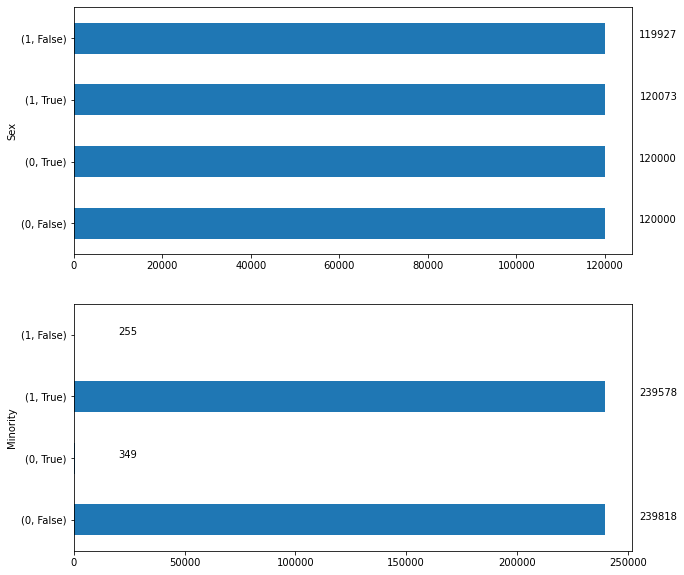

In [85]:
fig, (ax, ax2) = plt.subplots(2, 1,  figsize=(10,10), sharey=True)

df.groupby('sex').default.value_counts().plot(kind='barh',ax=ax)
ax.set_ylabel('Sex')
[ax.text(v+12000, i, '{:}'.format(v), horizontalalignment='center') for i, v in enumerate(df.groupby('sex').default.value_counts())]
df.groupby('minority').default.value_counts().plot(kind='barh',x=ax2)
ax2.set_ylabel('Minority')
[ax2.text(v+24000, i, '{:}'.format(v), horizontalalignment='center') for i, v in enumerate(df.groupby('minority').default.value_counts())]
plt.show()

We can see that there is a small difference in the distribution towards women getting more rejections than men. However, this can be due to random chance and we investigate if this really makes a difference. In the case of the minority feature it is quite obvious that the distributions differ a lot, as they are almost contrary to each other. That means that in most cases a person belonging to a minority is not getting a loan, which looks a lot like bias. 

We gonna investigate right now, if the distributions of the other variables differ a lot and if that could be a possible explanation for the differences for the minority feature. For this reason, we split the dataset based on the feature and have a look at the other variables.

In [20]:
#Minority
df_minor = df[df['minority'] == 0]
#No minority
df_no_minor = df[df['minority'] == 1]

In [21]:
# look at distribution
df_minor.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
minority,240167.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
sex,240167.00,0.50,0.50,0.00,0.00,1.00,1.00,1.00
rent,240167.00,0.05,0.22,0.00,0.00,0.00,0.00,1.00
education,240167.00,26.00,24.54,0.00,1.68,11.10,49.69,89.05
age,240167.00,43.01,14.43,18.00,30.47,43.05,55.49,68.00
income,240167.00,96153.16,91661.61,13.83,6167.06,43273.80,183377.34,350173.90
loan_size,240167.00,5001.26,2882.85,0.16,2504.95,4999.24,7494.36,9999.97
payment_timing,240167.00,3.00,1.00,-10.26,2.61,3.31,3.71,4.00
year,240167.00,14.50,8.65,0.00,7.00,15.00,22.00,29.00
job_stability,240167.00,89.86,14.15,0.12,79.34,89.42,100.05,149.91


In [22]:
# look at distribution
df_no_minor.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
minority,239833.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00
sex,239833.00,0.50,0.50,0.00,0.00,0.00,1.00,1.00
rent,239833.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
education,239833.00,26.04,24.56,0.00,1.68,29.00,49.72,89.31
age,239833.00,42.97,14.42,18.00,30.46,42.94,55.44,68.00
income,239833.00,96294.20,91783.16,7.31,6195.48,96139.18,183570.21,347753.62
loan_size,239833.00,5008.75,2891.46,0.04,2502.54,5018.53,7513.25,9999.99
payment_timing,239833.00,3.00,1.00,-12.46,2.62,3.31,3.71,4.00
year,239833.00,14.50,8.66,0.00,7.00,14.00,22.00,29.00
job_stability,239833.00,2.06,2.81,0.01,0.96,1.67,2.69,124.18


We see that in most cases the statistical propties of the features do not differ by a lot. However, there are two features that stand out: rent and job_stability. As a brief recap, rent indicates if a person currently pays rent (1) or not (0) and job_stability indicates how how secure a workplace is. It seems that peeople belonging to the minor class do not pay rent with a higher probability and have more insecure jobs. This might be a possible explanation.

In the following, we investigate how good an algorithm is able to predict that and if the distributions may further change due to bias.

# II. Preprocessing

Before we use an algorithm on the data, we gonna preprocess the features for better usage. In a first step, we round all the numerical features on two decimal places.

In [24]:
df = df.round(decimals = 2)